In [66]:
import torch
import pytorch3d
import h5py
import numpy as np
from medusa.data import get_example_h5, get_example_frame
import matplotlib.pyplot as plt
from pytorch3d.structures import Meshes

from pytorch3d.renderer import (
    look_at_view_transform,
    TexturesVertex,
    PerspectiveCameras,
    FoVPerspectiveCameras,
    PointLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardFlatShader
)

In [55]:
data = get_example_h5(load=False)
orig_img = get_example_frame(load_torch=True, device='cuda')
with h5py.File(data, 'r') as f_in:
    v = f_in['v'][:]
    f = f_in['tris'][:]

device = 'cuda'
v = v[[0], :, :]
v = torch.as_tensor(v, device=device, dtype=torch.float32)
f = torch.as_tensor(f, dtype=torch.int64, device=device)
verts_rgb = torch.ones_like(v, device=device)
textures = TexturesVertex(verts_rgb)
mesh = Meshes(v, f.repeat(v.shape[0], 1, 1), textures)

torch.Size([384, 480, 3])

In [233]:
near = 1
far = 10000
frame_height = orig_img.shape[0]
frame_width = orig_img.shape[1]
fy = orig_img.shape[1]
fov_y = 2 * np.arctan(frame_height / (2 * fy))
fov_y

0.7610127542247298

In [234]:
R = torch.tensor(device=device, data=[
    [-1., 0., 0.],
    [0., 1., 0.],
    [0., 0., -1.],
]).unsqueeze(0)

In [230]:
device = 'cuda'
cameras = FoVPerspectiveCameras(device=device, znear=near, zfar=far, fov=fov_y, degrees=False, R=R)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=(384, 480),
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardFlatShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

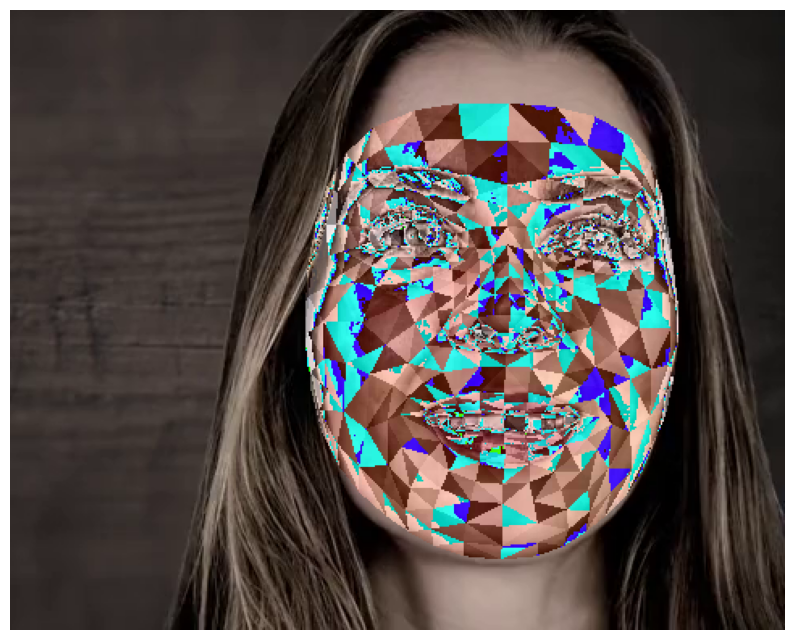

In [231]:
from tqdm import tqdm

imgs = renderer(mesh).squeeze(0) * 255
alpha = imgs[:, :, 3, None]
imgs = imgs[:, :, :3] * alpha + orig_img * (1 - alpha)
plt.figure(figsize=(10, 10))
plt.imshow(imgs[..., :3].cpu().numpy().astype(np.uint8))
plt.axis("off");